In [1]:
import os
import tempfile
import shutil
import urllib
import zipfile
import pandas as pd

# Temporary folder for data we need during execution of this notebook (we'll clean up
# at the end, we promise)
temp_dir = os.path.join(tempfile.gettempdir(), 'mind')
os.makedirs(temp_dir, exist_ok=True)

# The dataset is split into training and validation set, each with a large and small version.
# The format of the four files are the same.
# For demonstration purpose, we will use small version validation set only.
base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip'
validation_small_url = f'{base_url}/MINDsmall_dev.zip'
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'

In [2]:
def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename

In [3]:
# For demonstration purpose, we will use small version validation set only.
# This file is about 30MB.
zip_path = download_url(validation_small_url, verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

Bypassing download of already-downloaded file MINDsmall_dev.zip


['behaviors.tsv',
 'entity_embedding.vec',
 'https_mind201910small.blob.core.windows.net_release_MINDsmall_dev.zip',
 'news.tsv',
 'relation_embedding.vec']

In [8]:
# The behaviors.tsv file contains the impression logs and users' news click histories. 
# It has 5 columns divided by the tab symbol:
# - Impression ID. The ID of an impression.
# - User ID. The anonymous ID of a user.
# - Time. The impression time with format "MM/DD/YYYY HH:MM:SS AM/PM".
# - History. The news click history (ID list of clicked news) of this user before this impression.
# - Impressions. List of news displayed in this impression and user's click behaviors on them (1 for click and 0 for non-click).
behaviors_path = os.path.join(temp_dir, 'behaviors.tsv')
behaviors_df = pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

In [11]:
# The news.tsv file contains the detailed information of news articles involved in the behaviors.tsv file.
# It has 7 columns, which are divided by the tab symbol:
# - News ID
# - Category
# - Subcategory
# - Title
# - Abstract
# - URL
# - Title Entities (entities contained in the title of this news)
# - Abstract Entities (entities contained in the abstract of this news)
news_path = os.path.join(temp_dir, 'news.tsv')
news_df = pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])

In [12]:
# The entity_embedding.vec file contains the 100-dimensional embeddings
# of the entities learned from the subgraph by TransE method.
# The first column is the ID of entity, and the other columns are the embedding vector values.
entity_embedding_path = os.path.join(temp_dir, 'entity_embedding.vec')
entity_embedding = pd.read_table(entity_embedding_path, header=None)
entity_embedding['vector'] = entity_embedding.iloc[:, 1:101].values.tolist()
entity_embedding = entity_embedding[[0,
                                     'vector']].rename(columns={0: "entity"})
entity_embedding

,entity,vector
0,Q34433,"[0.017808, -0.073256, 0.102521, -0.059926, -0...."
1,Q41,"[-0.063388, -0.181451, 0.057501, -0.091254, -0..."
2,Q56037,"[0.02155, -0.044888, -0.027872, -0.128843, 0.0..."
3,Q1860,"[0.060958, 0.069934, 0.015832, 0.079471, -0.02..."
4,Q39631,"[-0.093106, -0.052002, 0.020556, -0.020801, 0...."
...,...,...
22888,Q278846,"[0.042413, 0.021957, 0.072414, -0.068437, 0.02..."
22889,Q54621949,"[-0.018299, -0.048378, -0.021645, -0.079743, 0..."
22890,Q42225228,"[-0.051346, -0.028947, -0.07587, 0.017512, -0...."
22891,Q54862508,"[-0.052323, -0.078029, -0.060925, -0.052536, 0..."


In [13]:
# The relation_embedding.vec file contains the 100-dimensional embeddings
# of the relations learned from the subgraph by TransE method.
# The first column is the ID of relation, and the other columns are the embedding vector values.
relation_embedding_path = os.path.join(temp_dir, 'relation_embedding.vec')
relation_embedding = pd.read_table(relation_embedding_path, header=None)
relation_embedding['vector'] = relation_embedding.iloc[:,
                                                       1:101].values.tolist()
relation_embedding = relation_embedding[[0, 'vector'
                                         ]].rename(columns={0: "relation"})
relation_embedding

,relation,vector
0,P31,"[-0.073467, -0.132227, 0.034173, -0.032769, 0...."
1,P21,"[-0.078436, 0.108589, -0.049429, -0.131355, 0...."
2,P106,"[-0.052137, 0.052444, -0.019886, -0.152309, 0...."
3,P735,"[-0.051398, 0.056219, 0.068029, -0.137717, -0...."
4,P108,"[0.091231, 0.022526, 0.059349, -0.141853, 0.03..."
...,...,...
1086,P1897,"[-0.019021, 0.001183, -0.009602, -0.040833, -0..."
1087,P3776,"[-0.018365, 0.028526, -0.025934, 0.032296, -0...."
1088,P1194,"[-0.026819, 0.003231, -0.011298, -0.015206, 0...."
1089,P2502,"[0.003554, -0.041121, -0.010559, -0.037862, -0..."


In [14]:
# 检查缺失值
print(behaviors_df.isnull().sum())
print(news_df.isnull().sum())
print(entity_embedding.isnull().sum())
print(relation_embedding.isnull().sum())

# 填充或清除缺失值
behaviors_df = behaviors_df.dropna()
news_df = news_df.dropna()
entity_embedding = entity_embedding.dropna()
relation_embedding = relation_embedding.dropna()


impression_id       0
user_id             0
time                0
history          2214
impressions         0
dtype: int64
id                      0
category                0
subcategory             0
title                   0
abstract             2021
url                     0
title_entities          2
abstract_entities       2
dtype: int64
entity    0
vector    0
dtype: int64
relation    0
vector      0
dtype: int64


In [15]:
# 检查缺失值
print(behaviors_df.isnull().sum())
print(news_df.isnull().sum())
print(entity_embedding.isnull().sum())
print(relation_embedding.isnull().sum())

impression_id    0
user_id          0
time             0
history          0
impressions      0
dtype: int64
id                   0
category             0
subcategory          0
title                0
abstract             0
url                  0
title_entities       0
abstract_entities    0
dtype: int64
entity    0
vector    0
dtype: int64
relation    0
vector      0
dtype: int64


In [18]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd

# 假设把用户的历史点击新闻视为一次交易
transaction_list = list(behaviors_df['history'].dropna().apply(lambda x: x.split()))

# 使用高效的编码方式
te = TransactionEncoder()
te_ary = te.fit(transaction_list).transform(transaction_list, sparse=True)

# 创建使用稀疏类型的DataFrame
sparse_df = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)

# 调整支持度阈值，减少频繁项集的数量
min_support = 0.02  # 根据数据集的特性适当调整
frequent_itemsets = apriori(sparse_df, min_support=min_support, use_colnames=True, low_memory=True)

# 生成关联规则
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
print(rules[['antecedents', 'consequents', 'support', 'confidence']])


   antecedents consequents   support  confidence
0     (N16715)    (N31801)  0.021794    0.264726
1     (N31801)    (N16715)  0.021794    0.229581
2     (N29177)      (N306)  0.022358    0.266107
3       (N306)    (N29177)  0.022358    0.165882
4       (N306)    (N31801)  0.024543    0.182094
5     (N31801)      (N306)  0.024543    0.258539
6     (N42620)      (N306)  0.032254    0.231861
7       (N306)    (N42620)  0.032254    0.239306
8     (N43142)      (N306)  0.026742    0.276853
9       (N306)    (N43142)  0.026742    0.198410
10      (N306)    (N45794)  0.025797    0.191403
11    (N45794)      (N306)  0.025797    0.240600
12      (N306)     (N4607)  0.021032    0.156051
13     (N4607)      (N306)  0.021032    0.232435
14    (N46392)      (N306)  0.023302    0.288180
15      (N306)    (N46392)  0.023302    0.172890
16    (N51706)      (N306)  0.020102    0.243886
17      (N306)    (N51706)  0.020102    0.149148
18    (N55189)      (N306)  0.021639    0.235141
19      (N306)    (N

E:\Programming\Aconda\envs\jupyter_notebook_3.9\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
E:\Programming\Aconda\envs\jupyter_notebook_3.9\lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
E:\Programming\Aconda\envs\jupyter_notebook_3.9\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
E:\Programming\Aconda\envs\jupyter_notebook_3.9\lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
E:\Programming\Aconda\envs\jupyter_notebook_3.9\lib\site-packages\matplotlib

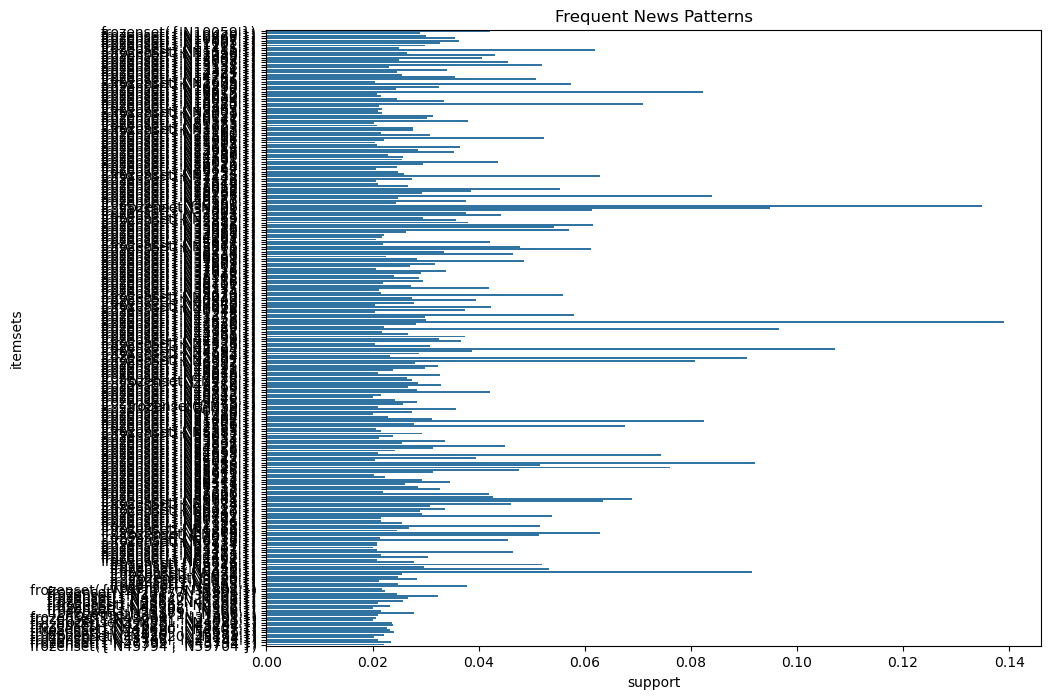

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制频繁项集的支持度
plt.figure(figsize=(10, 8))
sns.barplot(data=frequent_itemsets, x='support', y='itemsets')
plt.title('Frequent News Patterns')
plt.show()


C:\Users\18722\AppData\Local\Temp\ipykernel_42452\2761395158.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_rules, x='support', y='rule', palette='viridis')


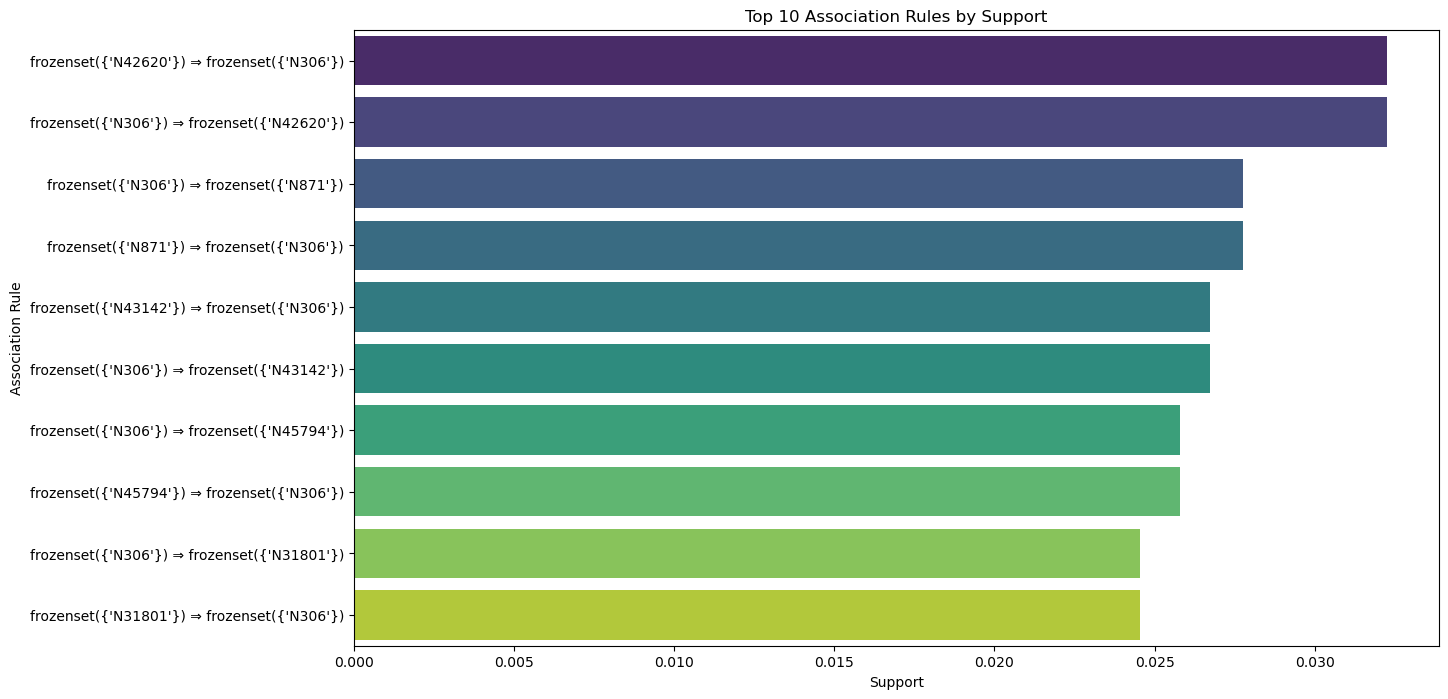

In [20]:
# 对关联规则按支持度排序且选择支持度最高的前十条规则
top_10_rules = rules.sort_values('support', ascending=False).head(10)
top_10_rules['rule'] = top_10_rules['antecedents'].astype(str) + ' ⇒ ' + top_10_rules['consequents'].astype(str)

# 绘制条形图展示这些规则的支持度
plt.figure(figsize=(14, 8))
sns.barplot(data=top_10_rules, x='support', y='rule', palette='viridis')
plt.title('Top 10 Association Rules by Support')
plt.xlabel('Support')
plt.ylabel('Association Rule')
plt.show()
